In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms

from torchcam.methods import LayerCAM
from torchcam.utils import overlay_mask

from PIL import Image
import matplotlib.pyplot as plt

import os

In [ ]:
model_name = "resnet18"
images_folder = "examples"
dataset_size = 250

model_path = f"/models/{model_name}/size_{dataset_size}.pt"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
state_dict = torch.load(model_path)['model_state_dict']
model = None

if model_name.startswith("vgg16"):
    model = models.vgg16(pretrained=True)
    pretrained_classifier = model.classifier[6]
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 2)


elif model_name.startswith("googlenet"):
    model = models.googlenet(pretrained=True)
    pretrained_fc = model.fc
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

elif model_name.startswith("resnet18"):
    model = models.resnet18(pretrained=True)
    pretrained_fc = model.fc
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

to_normalized_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
def load_images_from_folder(folder, transformer):
    images = []
    for filename in os.listdir(folder):
      img_path = os.path.join(folder, filename)
      img = Image.open(img_path)
      images.append(transformer(img))
    return images

In [ ]:
images = load_images_from_folder(images_folder, resize)
input_tensor = torch.stack(list(map(to_normalized_tensor, images))).to(device)

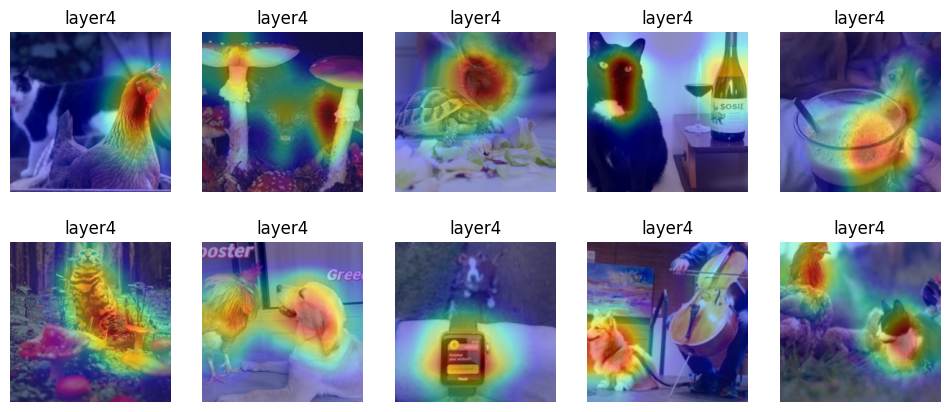

In [ ]:
cam_extractor = LayerCAM(model)

out = model(input_tensor)

cams = cam_extractor(out.argmax(axis=1).tolist(), out)

_, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()

for ti, name in enumerate(cam_extractor.target_names):
  for ii, (image, ax) in enumerate(zip(images, axs)):
      cam = cams[ti][ii]
      result = overlay_mask(image, transforms.functional.to_pil_image(cam.squeeze(0), mode='F'), alpha=0.6)
      ax.set_title(name)
      ax.axis('off')
      ax.imshow(result)
plt.show()

cam_extractor.remove_hooks()